In [40]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import geopy.distance

import os
import xarray as xr
import dask
from dask.distributed import Client

from dask.diagnostics import ProgressBar

import calculate_composites as cc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
subdomains = xr.open_dataset('/home/kbrennan/phd/data/climate/grids/subdomains.nc')
subdomains

<xarray.Dataset>
Dimensions:       (time: 1, bnds: 2, rlat: 1542, rlon: 1542)
Coordinates:
  * time          (time) datetime64[ns] 2020-03-19T03:00:00
    lon           (rlat, rlon) float32 ...
    lat           (rlat, rlon) float32 ...
  * rlon          (rlon) float32 -18.86 -18.84 -18.82 ... 11.92 11.94 11.96
  * rlat          (rlat) float32 -14.86 -14.84 -14.82 ... 15.92 15.94 15.96
Dimensions without coordinates: bnds
Data variables: (12/13)
    time_bnds     (time, bnds) datetime64[ns] ...
    rotated_pole  |S1 ...
    NAL           (time, rlat, rlon) float32 ...
    SAL           (time, rlat, rlon) float32 ...
    AL            (time, rlat, rlon) float32 ...
    BI            (time, rlat, rlon) float32 ...
    ...            ...
    FR            (time, rlat, rlon) float32 ...
    IP            (time, rlat, rlon) float32 ...
    MD            (time, rlat, rlon) float32 ...
    ME            (time, rlat, rlon) float32 ...
    NA            (time, rlat, rlon) float32 ...
    SC            (time, rlat, rlon) float32 ...
Attributes:
    history:  Tue May  7 16:04:10 2024: ncks -4 -L 1 -a -O /project/pr133/rcu...
    NCO:      netCDF Operators version 5.0.4 (Homepage = http://nco.sf.net, C...

In [27]:
dom = 'NA'
future = xr.open_dataset('/net/litho/atmosdyn2/kbrennan/data/climate/cookies/future/composites/'+dom+'_mean.nc')
present = xr.open_dataset('/net/litho/atmosdyn2/kbrennan/data/climate/cookies/present/composites/'+dom+'_mean.nc')
print(subdomains[dom].attrs['long_name'])

North Africa -10,11,30.5,37.5


In [28]:
present = present.squeeze()
future = future.squeeze()

In [29]:
present.domain

<xarray.DataArray 'domain' ()>
array('NA', dtype='<U2')
Coordinates:
    domain   <U2 'NA'

In [30]:
present.n_cookies.values

array(263)

In [31]:
diff = future - present

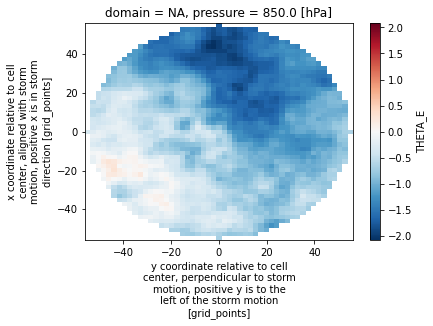

In [32]:
diff.THETA_E.sel(pressure=850).plot()

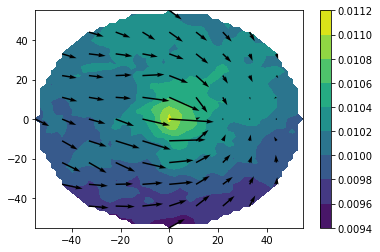

In [33]:
pressure = 925
plt.contourf(present.x, present.y, present.QV.sel(pressure=pressure))
plt.colorbar()
stride = 5
plt.quiver(
    present.x[::stride],
    present.y[::stride],
    present.U.sel(pressure=pressure)[::stride, ::stride],
    present.V.sel(pressure=pressure)[::stride, ::stride],
    scale=50,
)

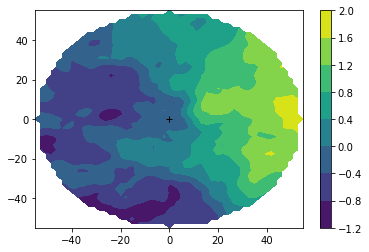

In [34]:
plt.contourf(diff.x,diff.y,diff.VMAX_10M)
plt.colorbar()
plt.plot(0,0,'k+')

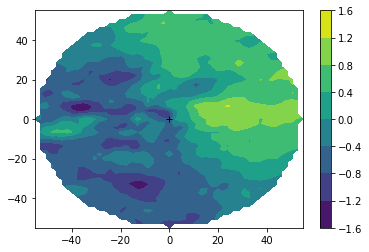

In [35]:
plt.contourf(diff.x,diff.y,diff.W_CTMAX)
plt.colorbar()
plt.plot(0,0,'k+')

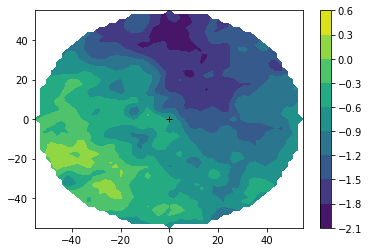

In [36]:
plt.contourf(diff.x,diff.y,diff.THETA_E.sel(pressure=850))
plt.colorbar()
plt.plot(0,0,'k+')

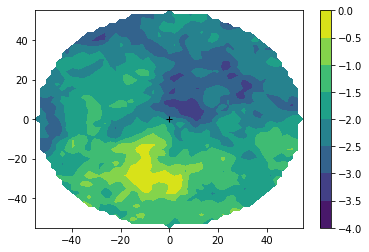

In [37]:
plt.contourf(diff.x,diff.y,diff.THETA_E.sel(pressure=925))
plt.colorbar()
plt.plot(0,0,'k+')

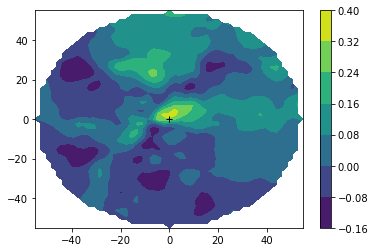

In [38]:
plt.contourf(diff.x,diff.y,diff.TOT_PREC)
plt.colorbar()
plt.plot(0,0,'k+')

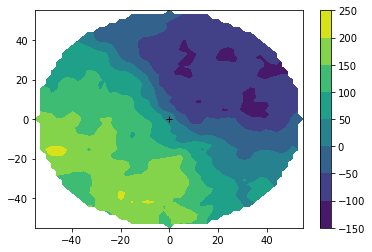

In [39]:
plt.contourf(diff.x,diff.y,diff.CAPE_MU)
plt.colorbar()
plt.plot(0,0,'k+')

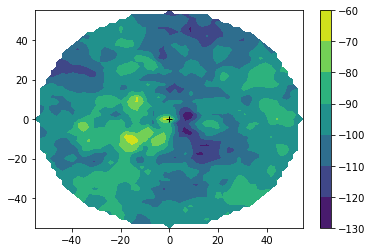

In [40]:
plt.contourf(diff.x,diff.y,diff.HZEROCL)
plt.colorbar()
plt.plot(0,0,'k+')

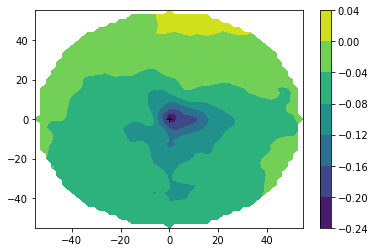

In [41]:
plt.contourf(diff.x,diff.y,diff.TQI)
plt.colorbar()
plt.plot(0,0,'k+')

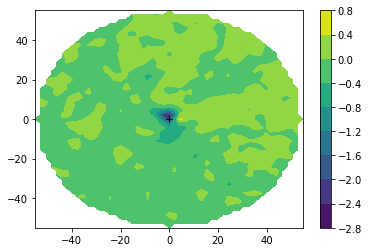

In [42]:
plt.contourf(diff.x,diff.y,diff.W.sel(pressure=400))
plt.plot(0,0,'k+')
plt.colorbar()

/tmp/ipykernel_41740/3060303146.py:3: UserWarning: No contour levels were found within the data range.
  plt.contour(present.x,present.y,present.W.sel(pressure=850),levels=[5],colors='k')


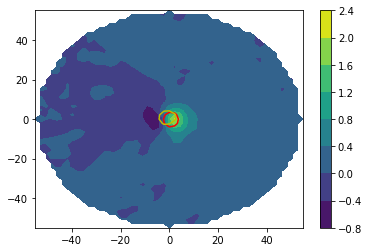

In [43]:
plt.contourf(present.x,present.y,present.W.sel(pressure=850))
plt.colorbar()
plt.contour(present.x,present.y,present.W.sel(pressure=850),levels=[5],colors='k')
plt.contour(present.x,present.y,present.W.sel(pressure=600),levels=[5],colors='r')
plt.contour(present.x,present.y,present.W.sel(pressure=300),levels=[5],colors='y')

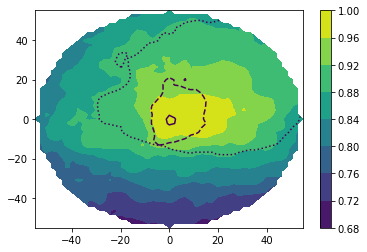

In [44]:
plt.contourf(present.x,present.y,present.CLCT)
plt.colorbar()
plt.contour(present.x,present.y,present.CLCL,levels=[0.7],linestyles=['solid'])
plt.contour(present.x,present.y,present.CLCM,levels=[0.8],linestyles=['dashed'])
plt.contour(present.x,present.y,present.CLCH,levels=[0.8],linestyles=['dotted'])

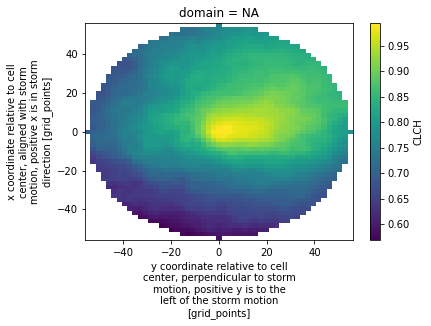

In [45]:
present.CLCH.plot()

In [46]:
# cp = xr.open_mfdataset('/home/kbrennan/phd/data/climate/cookies/present/subdomains/AL/*',combine='by_coords')
# cf = xr.open_mfdataset('/home/kbrennan/phd/data/climate/cookies/future/subdomains/AL/*',combine='by_coords')

In [47]:
# plt.scatter(cp.THETA_E.sel(pressure=850).sel(x=slice(30,60),y=slice(-20,20)).mean(dim=['x','y']),cp.DHAIL_MX.max(dim=['x','y']))